<a href="https://colab.research.google.com/github/ddg93/TF_flexfibreAABB/blob/main/Fibre_AABB_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
###import useful modules
import tensorflow as tf
from tensorflow import keras
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib import image
import cv2
import re
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.lines as mlines

In [3]:
#Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.11.0
[]


In [4]:
###Download the data set from Google Drive
!gdown 1odTuGm3v-klRlB6DAjx4JRtcDjBkW1TB -O data.zip
###Extract the data set
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('')

Downloading...
From: https://drive.google.com/uc?id=1odTuGm3v-klRlB6DAjx4JRtcDjBkW1TB
To: /content/data.zip
100% 355k/355k [00:00<00:00, 125MB/s]


In [5]:
###Set the path of the data set and list all files within
folder = 'loop_line/'
filenames = next(os.walk(folder),(None,None,[]))[2]
###Look for the .jpg image files and the .txt label files 
images = [x for x in filenames if x[-4:] == '.jpg']
labels = [x for x in filenames if x[-4:] == '.txt']
###Read the int key in the file names
img_inds = []
lbl_inds = []
for img, lbl in zip(images, labels):
  img_inds.append(int(re.search(r'\d+', img).group()))
  lbl_inds.append(int(re.search(r'\d+', lbl).group()))
###sort the lists according to their int keys
labels = [x for _, x in sorted(zip(lbl_inds, labels))]
images = [x for _, x in sorted(zip(img_inds, images))]
###load the labels as the coordinates of the 4 courners of the Axes-Aligned Bounding Box: x0, y0, xend and yend
lbs=[]
for label in labels:
  x,y,w,h = np.loadtxt(folder+label).astype(int)
  lbs.append([x,y,x+w,y+h])
###load the images
ims = []
for imag in images:
  tmp = Image.open(folder+imag)
  img = np.array(tmp)
  ims.append(img)

In [6]:
###convert to array and normalize
ims = np.array(ims) / 255.0 #normalize the colors by 255 so they fall in the range 0,1
lbs = np.array(lbs) / img.shape[0] #normalize the AABB points by 400 so they fall in the range 0,1
# split between training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(ims, lbs, test_size=0.2, random_state=0)

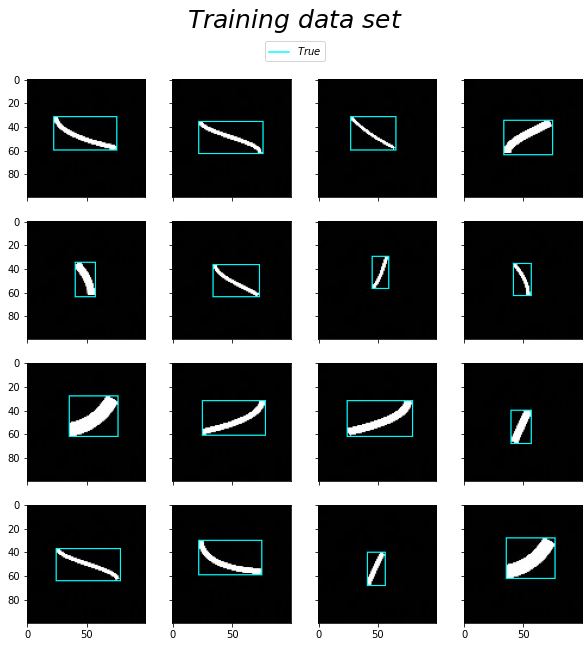

In [7]:
###Visualize the data set: look at 16 random images
fig,axs = plt.subplots(4,4,sharex=True,sharey=True,figsize=(10,10))  ###create the array of images
inds = np.random.randint(0,len(X_train),axs.shape[0]*axs.shape[1]) ###select 16 random indexes
for j in range(axs.shape[0]):
  for i in range(axs.shape[1]):
    img = (X_train[inds[i+axs.shape[1]*j]]*255).astype(np.uint8)   ###load the image
    x0,y0,xend,yend = (Y_train[inds[i+axs.shape[1]*j]]*img.shape[0]).astype(int)###load the AABB corners
    res = cv2.rectangle(img,(x0,y0), (xend,yend), (0,255,255),1) ###draw the AABB
    axs[j][i].imshow(res) ###plot the image
fig.suptitle(r'$Training  \ data \ set$', fontsize=25);
###Prepare the labels and plot the legend
tr = mlines.Line2D([], [], color='cyan', label=r'$True$')
fig.legend(handles=[tr],loc='upper center',ncol=1,bbox_to_anchor=(0.5,0.94));


In [23]:
###Build the model
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(4, (3,3), activation='relu', input_shape=(100,100,3)), ###2D Convolutional layer: size (100,100,3) (size of the images)
        tf.keras.layers.MaxPooling2D(2,2),                                            ###MaxPooling
        tf.keras.layers.Flatten(),                                                    ###Flatten layer
        tf.keras.layers.Dense(128, activation='relu'),                                ###Dense layers to perform the regression
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(4, activation='relu')                                   ###Final layer: size 4 (4 coordinates of the AABB)
])
###Compile the model
model.compile(loss='mean_squared_error', optimizer="adam", metrics=["accuracy"])
###Report of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 4)         112       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 49, 49, 4)        0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 9604)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               1229440   
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                      

In [24]:
###Fit the model on the training data set
histo = model.fit(X_train, Y_train, epochs=10, batch_size=16,  verbose=1)

Epoch 1/10
10/10 [==============================] - 2s 63ms/step - loss: 0.0925 - accuracy: 0.4500
Epoch 2/10
10/10 [==============================] - 1s 61ms/step - loss: 0.0138 - accuracy: 0.8062
Epoch 3/10
10/10 [==============================] - 1s 59ms/step - loss: 0.0061 - accuracy: 0.6812
Epoch 4/10
10/10 [==============================] - 1s 58ms/step - loss: 0.0030 - accuracy: 0.8125
Epoch 5/10
10/10 [==============================] - 1s 59ms/step - loss: 0.0016 - accuracy: 0.9625
Epoch 6/10
10/10 [==============================] - 1s 60ms/step - loss: 9.5069e-04 - accuracy: 0.9375
Epoch 7/10
10/10 [==============================] - 1s 58ms/step - loss: 5.0004e-04 - accuracy: 0.9875
Epoch 8/10
10/10 [==============================] - 1s 60ms/step - loss: 3.0498e-04 - accuracy: 0.9937
Epoch 9/10
10/10 [==============================] - 1s 63ms/step - loss: 1.9864e-04 - accuracy: 0.9812
Epoch 10/10
10/10 [==============================] - 1s 60ms/step - loss: 1.7747e-04 - accura

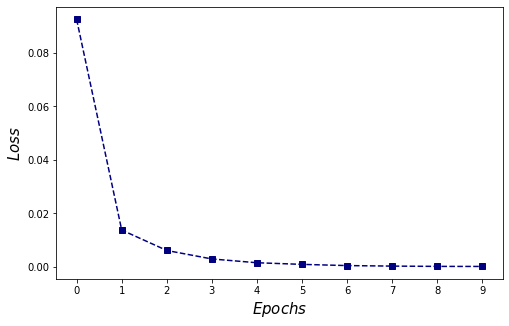

In [25]:
###Display the Loss against the Epoch number
plt.figure(figsize=(8,5))
plt.plot(histo.epoch,histo.history['loss'],marker='s',c='navy',ls='--')
plt.xticks(histo.epoch)
plt.xlabel(r'$Epochs$',fontsize=15)
plt.ylabel(r'$Loss$',fontsize=15);

In [33]:
###Evaluate the test set
Y_pred = model.predict(X_test)
###Calculate the Mean Squared Error between true and predicted AABBs
mse = tf.keras.metrics.mean_squared_error(Y_test, Y_pred)
print('Mean Squared Error between true and predicted AABBs:')
print('{} '.format(str(np.mean(mse)*100)))

2/2 [==============================] - 0s 29ms/step
Mean Squared Error between true and predicted AABBs:
0.08801993099041283 


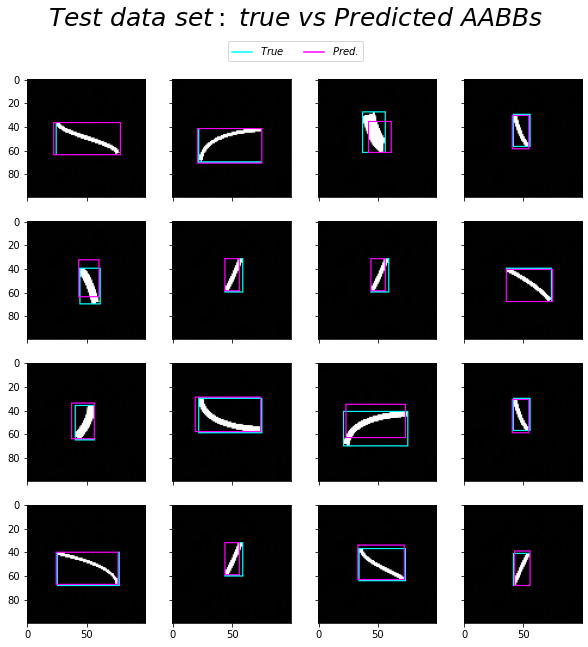

In [27]:
###Visualize the data set: look at 16 random images
fig,axs = plt.subplots(4,4,sharex=True,sharey=True,figsize=(10,10))  ###create the array of images
inds = np.random.randint(0,len(X_test),axs.shape[0]*axs.shape[1]) ###select 16 random indexes
for j in range(axs.shape[0]):
  for i in range(axs.shape[1]):
    ###Load the image from the test data set
    img = (X_test[inds[i+axs.shape[1]*j]]*255).astype(np.uint8)   ###load the image
    ###Load and display the true value of the AABB
    x0,y0,xend,yend = (Y_test[inds[i+axs.shape[1]*j]]*img.shape[0]).astype(int)###load the AABB corners
    res = cv2.rectangle(img,(x0,y0), (xend,yend), (0,255,255),1) ###draw the AABB
    ###Load and display the predicted value of the AABB
    x0,y0,xend,yend = (Y_pred[inds[i+axs.shape[1]*j]]*img.shape[0]).astype(int)###load the AABB corners
    res = cv2.rectangle(img,(x0,y0), (xend,yend), (255,0,255),1) ###draw the AABB
    axs[j][i].imshow(res) ###plot the sub-figure
###Set the title
fig.suptitle(r'$Test \ data \ set: \ true \ vs \ Predicted \ AABBs$', fontsize=25);
###Prepare the labels and plot the legend
tr = mlines.Line2D([], [], color='cyan', label=r'$True$')
pr = mlines.Line2D([], [], color='Magenta', label=r'$Pred.$')
fig.legend(handles=[tr, pr],loc='upper center',ncol=2,bbox_to_anchor=(0.5,0.94));